# Pneunomia detection

1. Step: Reading pictures in

In [4]:
# lehetséges modellek amik jók lehetnek: resnet50(ezzel csináltam a betűfelismerést), sequential(ez vol kaggle-on), svm(ez volt amm órán), 

ütemterv:
- Rövid helyzetjelentés emailben (sikerült-e a haladni, mi a helyzet), minden héten kedden (akkor is, ha épp nem volt rá idő vagy energia)
- Április 10-ig: kész és dokumentált feltáró adatelemzés (EDA)
- Április 19-ig: teljes, kész irodalomkutatás - adatbányászat + EDA alapok + gépi tanulás és algoritmusok melyeket használni fogsz
- Május 7-ig: elkészült gépi tanulási modellek és az eredmények értékelése 
- Május 13-ig: Benyújtásra kész, általad véglegesnek ítélt dokumentáció elküldése nekem (az osztályzatnál figyelembe lesz véve az állapota) 
- Május 24-ig: Az egyetemnek benyújtott dokumentáció (végső értékeléshez) 
- Teljesen kész prezentáció a prezentáció előtt egy héttel legalább

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import tqdm
import glob

#resnet importalasa
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [4]:
# beolvasas
train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]

Betoltes: 100%|██████████| 3875/3875 [01:52<00:00, 34.36it/s]


In [5]:
len(train_normal)
len(train_pneunomia)

3875

# Feltáró adatelemzés (Exploratory Data Analysis)

<Axes: title={'center': 'Number of images by class'}, xlabel='Class name', ylabel='Number of pictures'>

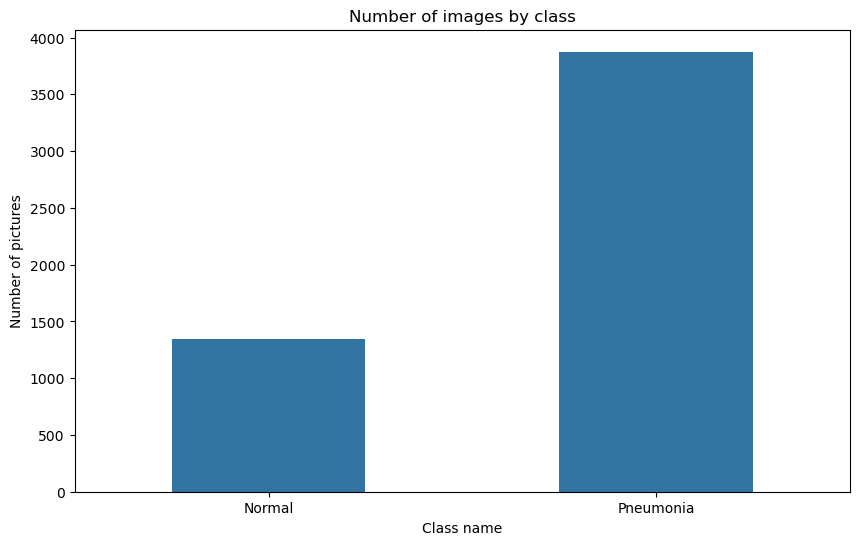

In [ ]:
# class imbalance:
#making it a dictionary
classes = {'Normal':len(train_normal), 'Pneumonia':len(train_pneunomia) }
plt.figure(figsize=(10,6))
plt.title('Number of images by class')
plt.xlabel('Class name')
plt.ylabel('Number of pictures')
sns.barplot(classes,width=0.5)



Konklúzió: Látható, hogy fetőzött tüdőről lényegesen több kép van mint normálisról, ezáltal előfordulhat egyenlőtlenség

In [26]:
# checking the image sizes
def get_dimensions(dataset):
    dimensions = pd.DataFrame(columns=['height', 'width'])
    for i in range(0, len(dataset)):
        im = dataset[i]
        array = np.array(im)
        h,w,d = array.shape
        dimensions.loc[len(dimensions)] = [h,w]
    return dimensions

In [16]:
normal_df = get_dimensions(train_normal)

<Axes: title={'center': 'Distribution of image sizes for normal lungs'}, xlabel='height', ylabel='width'>

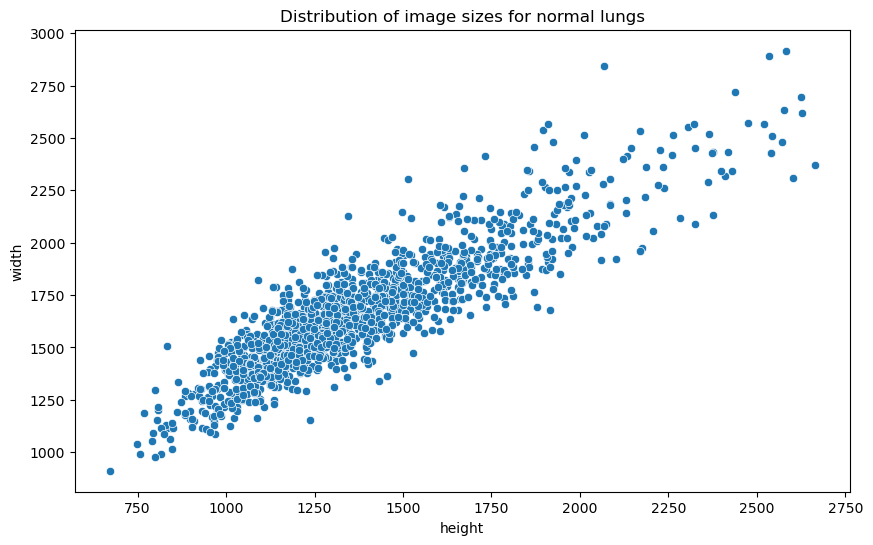

In [ ]:
# plotting image sizes
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for normal lungs')
sns.scatterplot(data=normal_df, x='height', y='width')

In [27]:
pneumonia_df = get_dimensions(train_pneunomia)

<Axes: title={'center': 'Distribution of image sizes for infected lungs'}, xlabel='height', ylabel='width'>

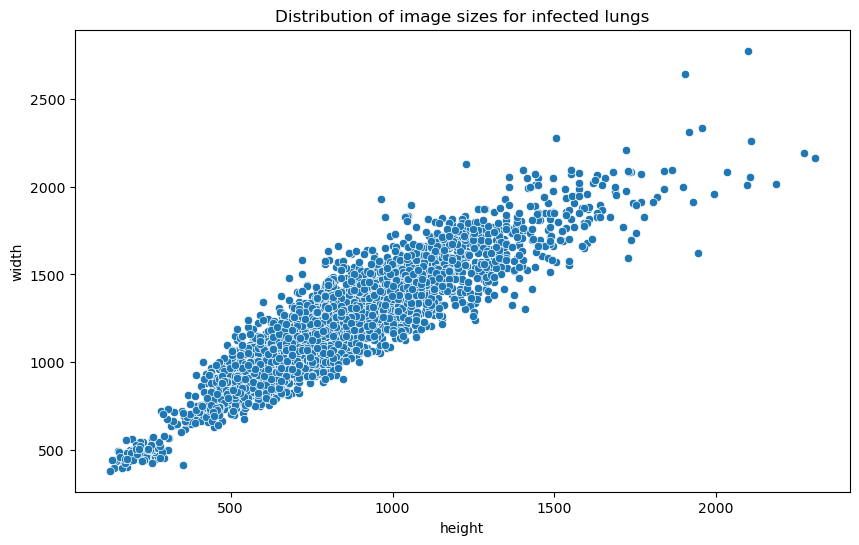

In [28]:
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for infected lungs')
sns.scatterplot(data=pneumonia_df, x='height', y='width')

Konklúzió: A képek egyáltalán nem egységesek, nagyon sokféle méretben vannak jelen az adatbázisban

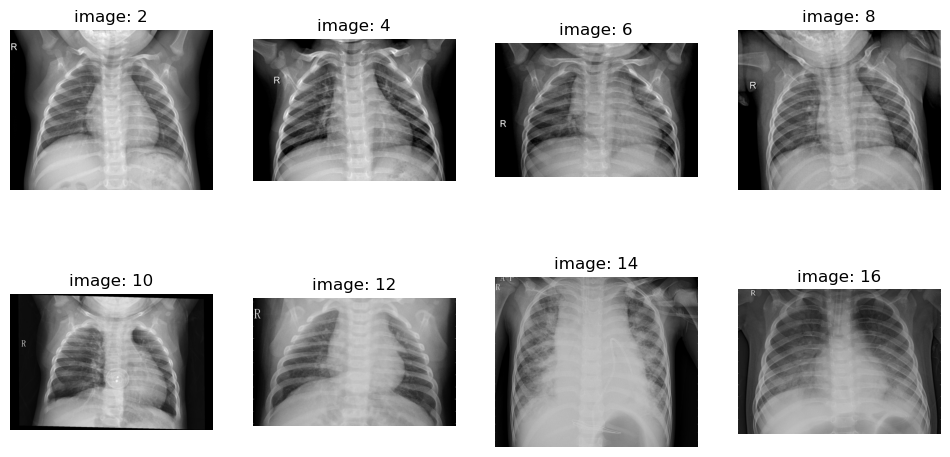

In [53]:
# Showing examples from each class
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i) #sor,oszlop,melyiknel legyen epp
    if i < 5:
        plt.imshow(train_normal[i*2])
        plt.title(f"image: {i*2}")
        plt.axis('off')
    else:
        plt.imshow(train_pneunomia[i*2]) 
        plt.axis('off')
        plt.title(f"image: {i*2}")
